In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil

In [5]:
df = pd.read_csv('train.csv') # para leer el archivo que contiene la info de plantas 

In [24]:
df.head()

,image_id,healthy,multiple_diseases,rust,scab,label,image_id_jpg
0,Train_0,0,0,0,1,scab,Train_0.jpg
1,Train_1,0,1,0,0,multiple_diseases,Train_1.jpg
2,Train_2,1,0,0,0,healthy,Train_2.jpg
3,Train_3,0,0,1,0,rust,Train_3.jpg
4,Train_4,1,0,0,0,healthy,Train_4.jpg


In [7]:
CSV_PATH = "train.csv"
ORIGINAL_IMAGES_DIR = "images/" # La carpeta con todas las imagenes
NEW_BASE_DIR = "plant_dataset/" # Nombre de la carpeta a crear

In [9]:
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1) #label (columnas )

In [11]:
df['image_id_jpg'] = df['image_id'] + ".jpg" #para que pueda leer las imágenes con los indices en la columna

In [13]:
df_dev, df_final_test = train_test_split(
    df,
    test_size=0.30, # 30% de los datos para una prueba final, el resto de entrenamiento y validación
    random_state=123,
    stratify=df['label']
)

In [15]:
df_train, df_validation = train_test_split(
    df_dev,
    test_size=0.15,          # Ahora probaré con 15% de validación sobre los datos de entrenamiento
    random_state=123,         # semilla
    stratify=df_dev['label']
)

In [17]:
classes = df['label'].unique() # 4 clases

In [19]:
# Función para crear las carpetas y mover los archivos
def setup_folders(dataframe, split_name):
    # (split_name será 'train' o 'validation')
    
    # Crear la carpeta base 
    split_dir = os.path.join(NEW_BASE_DIR, split_name)
    os.makedirs(split_dir, exist_ok=True)
    
    # Crear las subcarpetas de clases (carpeta de entrenamiento para cada clase )
    for class_name in classes:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)
        
    # Copiar los archivos, copia cada imagen  para ponerla en la carpeta de destino que se ha creado
    for _, row in dataframe.iterrows():
        image_name = row['image_id_jpg']
        label = row['label']
        
        # Ruta de origen (de dónde viene la imagen)
        source_path = os.path.join(ORIGINAL_IMAGES_DIR, image_name)
        
        # Ruta de destino (a dónde va la imagen)
        dest_path = os.path.join(split_dir, label, image_name)
        
        # Copiar el archivo (si no existe ya)
        if not os.path.exists(dest_path):
            shutil.copyfile(source_path, dest_path)

In [21]:
# Una carpeta base de validación y una de entrenamiento
setup_folders(df_train, 'train')
setup_folders(df_validation, 'validation')

In [41]:
IMAGE_SIZE = (180, 180)  #tamaño de la imagen
BATCH_SIZE = 32          # tamaño del mini batch

TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"

# Cargamos los datos
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical' #para 4 clases 
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Capa para aumento de datos
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), 
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation"
)

Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.


In [43]:
# Cargar modelo base, ahora usaré vgg16
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,)
)

# Primero con todos los parámetros entrenables congelados
conv_base.trainable = False
conv_base. summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = keras.applications.vgg16.preprocess_input(x) # Normalización de VGG16
x = conv_base(x)
x = layers.Flatten()(x)        #aplanar características 
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)       #evita el sobreajuste
outputs = layers.Dense(4, activation="softmax")(x) 
model = keras.Model(inputs, outputs)


In [ ]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model.summary() 

# entrenar la primera parte solo con clasificador (fase 1)
callbacks = [
    ModelCheckpoint(
        filepath="vgg16_fase1.keras",
        save_best_only=True,
        monitor="val_accuracy"
    )
]

history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

In [49]:
test_model = keras.models.load_model('vgg16_fase1.keras')

In [65]:
from tensorflow.keras.models import load_model
model = load_model("vgg16_fase1.keras")

In [53]:
# Descongelamos las últimas capas para el fine tuning
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [59]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_accuracy")
]

In [69]:
history_finetune = model.fit(
    train_dataset,
    epochs=30, # Entrena por 30 épocas nuevas
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 412s 12s/step - accuracy: 0.6414 - loss: 1.1120 - val_accuracy: 0.6615 - val_loss: 1.1137
Epoch 2/30
 1/34 ━━━━━━━━━━━━━━━━━━━━ 5:09 9s/step - accuracy: 0.6562 - loss: 1.4740

KeyboardInterrupt: 

Podemos hacer lo mismo, pero ahora con el modelo que habíamos estado trabajando (EfficientNetV2B0)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

IMAGE_SIZE = (224, 224) # Tamaño nativo de B0
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Optimizar los datasets para velocidad
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation"
)

#cargar el modelo
conv_base = EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="efficientnetv2-b0"
)

# Primero sin pesos entrenados
conv_base.trainable = False


inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = layers.Rescaling(1./255)(x) 
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=["accuracy"]
)

model.summary()

callbacks = [
    ModelCheckpoint("effnetv2b0_fase1_segura.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True), # Más paciencia
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_dataset,
    epochs=50, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

print("\n--- FASE 1 COMPLETADA ---")
print(f"Mejor val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")

Cargando datasets...
Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.
¡Datasets listos!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 5,921,872 (22.59 MB)


--- Iniciando FASE 1 (Con LR ultra-seguro de 1e-5) ---
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.1969 - loss: 1.6600 - val_accuracy: 0.3229 - val_loss: 1.3833 - learning_rate: 1.0000e-05
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.2237 - loss: 1.5843 - val_accuracy: 0.3229 - val_loss: 1.3735 - learning_rate: 1.0000e-05
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.2662 - loss: 1.4851 - val_accuracy: 0.3229 - val_loss: 1.3694 - learning_rate: 1.0000e-05
Epoch 4/50


Este ha salido mal, entonces ahora probaré con ResNet50V2

#### Intenos con ResNet

In [21]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input 

IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"

print("Cargando datasets...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("¡Datasets listos!")

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation"
)

conv_base = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="resnet50v2"
)

print("Iniciando FASE 1: Extracción (Base Congelada)")


conv_base.trainable = False

# Construir el Modelo 
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = conv_base(x, training=False) 

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)

#3Compilar
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
)

model.summary()

# Entrenar FASE 1
callbacks = [
    ModelCheckpoint("resnet_fase1.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

print(f"\nFASE 1 COMPLETADA. Mejor val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")

Cargando datasets...
Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.
¡Datasets listos!
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Iniciando FASE 1: Extracción (Base Congelada)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.4612 - loss: 1.2972 - val_accuracy: 0.5885 - val_loss: 0.9881 - learning_rate: 1.0000e-04
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.5555 - loss: 1.0799 - val_accuracy: 0.6562 - val_loss: 0.8908 - learning_rate: 1.0000e-04
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6100 - loss: 0.9670 - val_accuracy: 0.6823 - val_loss: 0.8389 - learning_rate: 1.0000e-04
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.6497 - loss: 0.8889 - val_accuracy: 0.7240 - val_loss: 0.7885 - learning_rate: 1.0000e-04
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.6728 - loss: 0.8361 - val_accuracy: 0.7292 - val_loss: 0.7712 - learning_rate: 1.0000e-04
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.6895 - loss: 0.7985 - val_accuracy: 0.7292 - val_loss: 0.7499 - learning_rate: 1.0000e-04
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7144 

Ha salido bastante mejor y podemos pasar a la fase 2, aplicando fine tuning, es decir descongelando las últimas capas del modelo para entrenar con las imagenes de plantas específicamente.

In [27]:
from tensorflow.keras.models import load_model
modelrn = load_model('resnet_fase1.keras')

In [33]:
conv_base = modelrn.get_layer('resnet50v2')
conv_base.trainable = True

# Descongelaré las capas de batchnormalization dentro de la base
for layer in conv_base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [35]:
modelrn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,141,518 (95.91 MB)

 Trainable params: 23,999,492 (91.55 MB)

 Non-trainable params: 90,880 (355.00 KB)

 Optimizer params: 1,051,146 (4.01 MB)

In [45]:
modelrn.compile(
    loss='categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate=1e-5),
    metrics = ['accuracy']
)

In [47]:
callbacks_finetune = [
    ModelCheckpoint(
        filepath="resnet_fine_tuning.keras", 
        save_best_only=True,
        monitor="val_accuracy"
    ),
  
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    
    EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, restore_best_weights=True)
]

In [49]:
last_epoch_fase1 = len(history.history['loss']) #última época entrenada en fase 1

In [51]:
history_finetune = modelrn.fit(
    train_dataset, 
    epochs=last_epoch_fase1 + 30, #entrenar otras 30 épocas
    initial_epoch=last_epoch_fase1, # empezar donde se quedó el entrenamiento en fase 1
    validation_data=validation_dataset, 
    callbacks=callbacks_finetune
)

Epoch 24/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 436s 12s/step - accuracy: 0.8216 - loss: 0.5262 - val_accuracy: 0.8438 - val_loss: 0.4634 - learning_rate: 1.0000e-05
Epoch 25/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 459s 14s/step - accuracy: 0.8632 - loss: 0.3913 - val_accuracy: 0.8490 - val_loss: 0.4433 - learning_rate: 1.0000e-05
Epoch 26/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 414s 12s/step - accuracy: 0.8734 - loss: 0.3460 - val_accuracy: 0.8698 - val_loss: 0.3610 - learning_rate: 1.0000e-05
Epoch 27/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 456s 13s/step - accuracy: 0.8891 - loss: 0.3170 - val_accuracy: 0.8802 - val_loss: 0.3631 - learning_rate: 1.0000e-05
Epoch 28/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 401s 12s/step - accuracy: 0.9057 - loss: 0.2704 - val_accuracy: 0.8698 - val_loss: 0.3617 - learning_rate: 1.0000e-05
Epoch 29/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 444s 13s/step - accuracy: 0.9057 - loss: 0.2361 - val_accuracy: 0.8802 - val_loss: 0.3574 - learning_rate: 1.0000e-05
Epoch 30/53
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accur

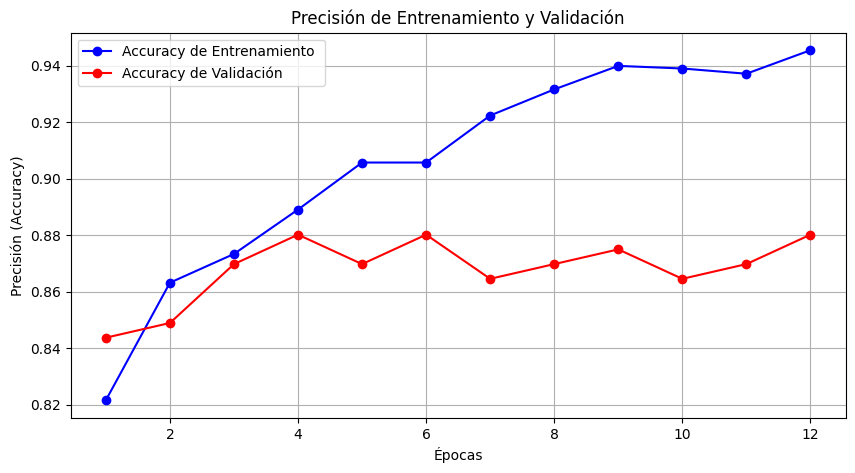

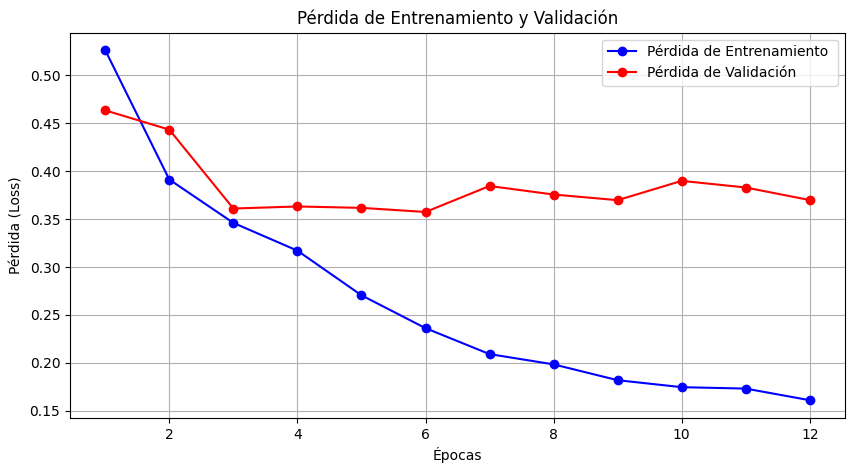

In [53]:
import matplotlib.pyplot as plt

#historial del finetuning
history_dict = history_finetune.history

# Gráfica de accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Accuracy de Entrenamiento ')
plt.plot(epochs, val_acc, 'ro-', label='Accuracy de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de la función de pérdida
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Pérdida de Entrenamiento ')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación ')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Podemos observar que existe un sobreajuste en los datos, memoriza los de entrenamiento y eso hace que no tenga la misma precisión que en validación.

#### Otro intento con ResNet

In [25]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input 

IMAGE_SIZE = (224, 224) 
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"


train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Optimizar los datasets para velocidad
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Añadí algunas transformaciones 
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation"
)

conv_base = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="resnet250v2"
)


conv_base.trainable = False

# Construir el Modelo 
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = conv_base(x, training=False) 

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.6)(x)  # subí el dropout por el sobreajuste mostrado en las gráficas anteriores  
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# 7. Compilar
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
)

model.summary()

# 8. Entrenar FASE 1
callbacks = [
    ModelCheckpoint("resnet2_fase1.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

print(f"\nFASE 1 COMPLETADA. Mejor val_accuracy: {max(history.history.get('val_accuracy', [0])):.4f}")

Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet250v2 (Functional)        │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/30


KeyboardInterrupt: 

In [27]:
from tensorflow.keras.models import load_model
model2rn = load_model('resnet2_fase1.keras')

In [29]:
conv_base = model2rn.get_layer('resnet250v2')
conv_base.trainable = True

# Descongelaré las capas de batchnormalization dentro de la base
for layer in conv_base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [31]:
model2rn.compile(
    loss='categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate=5e-6),
    metrics = ['accuracy']
)

In [33]:
callbacks_finetune = [
    ModelCheckpoint(
        filepath="Resnet2_fine_tuning.keras", 
        save_best_only=True,
        monitor="val_accuracy"
    ),
  
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1),
    
    EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, restore_best_weights=True)
]

In [43]:
history_finetune = model2rn.fit(
    train_dataset, 
    epochs=20, 
    validation_data=validation_dataset, 
    callbacks=callbacks_finetune
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 438s 13s/step - accuracy: 0.7847 - loss: 0.6148 - val_accuracy: 0.8385 - val_loss: 0.5237 - learning_rate: 5.0000e-06
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 408s 12s/step - accuracy: 0.8290 - loss: 0.5099 - val_accuracy: 0.8542 - val_loss: 0.4659 - learning_rate: 5.0000e-06
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 438s 12s/step - accuracy: 0.8355 - loss: 0.5048 - val_accuracy: 0.8594 - val_loss: 0.4455 - learning_rate: 5.0000e-06
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 390s 11s/step - accuracy: 0.8438 - loss: 0.4501 - val_accuracy: 0.8646 - val_loss: 0.4150 - learning_rate: 5.0000e-06
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 405s 12s/step - accuracy: 0.8577 - loss: 0.4156 - val_accuracy: 0.8646 - val_loss: 0.4014 - learning_rate: 5.0000e-06
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 387s 11s/step - accuracy: 0.8512 - loss: 0.4192 - val_accuracy: 0.8750 - val_loss: 0.3978 - learning_rate: 5.0000e-06
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 405s 10s/step - accuracy: 

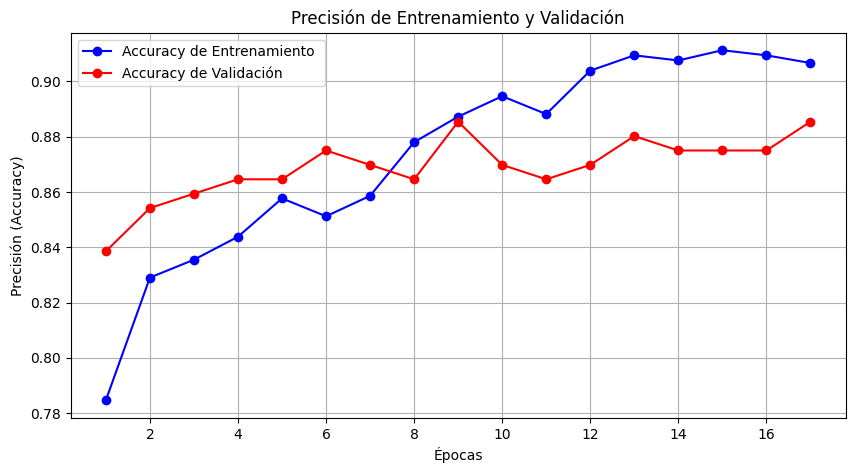

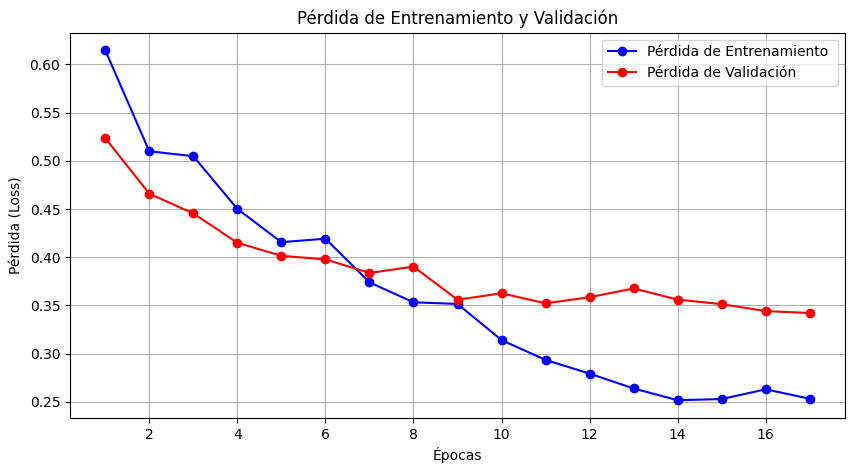

In [45]:
import matplotlib.pyplot as plt

#historial del finetuning
history_dict = history_finetune.history

# Gráfica de accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Accuracy de Entrenamiento ')
plt.plot(epochs, val_acc, 'ro-', label='Accuracy de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de la función de pérdida
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Pérdida de Entrenamiento ')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación ')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show()

Han mejorado las gráficas pero no la precisión del modelo, igual tenemos menos sobreajuste

#### Intento con EfficientNetV2B2

Como siguiente intento aplicaremos características similares para trabajar con la red entrenada de EfficientNetB2

In [23]:
from tensorflow.keras.applications import EfficientNetV2B2 

IMAGE_SIZE = (260, 260) 
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"


train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)



# Capa de aumento de datos igual que en el anterior modelo
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation"
)

# Ahora con el modelo de EfficientNetV2B2
conv_base = EfficientNetV2B2(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="efficientnetv2-b2"
)


# primero con la base congelada (fase 1)
conv_base.trainable = False

# construcción del modelo
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = layers.Rescaling(1./255)(x)
x = conv_base(x, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.6)(x) # dropout algo alto para evitar sobreajuste
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
)

model.summary()

# Entrenar fase 1
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,131,106 (34.83 MB)

 Trainable params: 361,732 (1.38 MB)

 Non-trainable params: 8,769,374 (33.45 MB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.3152 - loss: 1.3015 - val_accuracy: 0.3438 - val_loss: 1.2482 - learning_rate: 1.0000e-04
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.3152 - loss: 1.2800 - val_accuracy: 0.3438 - val_loss: 1.2479 - learning_rate: 1.0000e-04
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3258 - loss: 1.2963
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.3327 - loss: 1.2737 - val_accuracy: 0.3438 - val_loss: 1.2439 - learning_rate: 1.0000e-04
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.3096 - loss: 1.2822 - val_accuracy: 0.3438 - val_loss: 1.2435 - learning_rate: 2.0000e-05
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2862 - loss: 1.2922
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.3207 - loss: 1.263

Ha salido mal, como la anterior, haré la prueba con efficientNetV2B0.

In [34]:
from tensorflow.keras.applications import EfficientNetV2B0

IMAGE_SIZE = (260, 260) 
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"


train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)



# Capa de aumento de datos igual que en el anterior modelo
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation"
)

# Ahora con el modelo de EfficientNetV2B2
conv_base = EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="efficientnetv2-b0"
)


# primero con la base congelada (fase 1)
conv_base.trainable = False

# construcción del modelo
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = layers.Rescaling(1./255)(x)
x = conv_base(x, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.6)(x) # dropout algo alto para evitar sobreajuste
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
)

model.summary()

# Entrenar fase 1
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 9, 9, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,248,276 (23.84 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.2921 - loss: 1.3144 - val_accuracy: 0.3438 - val_loss: 1.2483 - learning_rate: 1.0000e-04
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.3253 - loss: 1.2777 - val_accuracy: 0.3438 - val_loss: 1.2463 - learning_rate: 1.0000e-04
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2829 - loss: 1.2917
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.2856 - loss: 1.2794 - val_accuracy: 0.3438 - val_loss: 1.2434 - learning_rate: 1.0000e-04
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.3179 - loss: 1.2609 - val_accuracy: 0.3438 - val_loss: 1.2423 - learning_rate: 2.0000e-05
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3214 - loss: 1.2748
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.3244 - loss: 1.261

Por último intentaré de nuevo con Vgg con algunos cambios con respecto del anterior intento  con esa red.

#### Intento con vgg

In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32
TRAIN_DIR = "plant_dataset/train/"
VALIDATION_DIR = "plant_dataset/validation/"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# Optimizar los datasets
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
    ],
    name="data_augmentation"
)

conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    name="vgg16" 
)

#fase 1 sin capas entrenables
conv_base.trainable = False

inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = conv_base(x) 
x = layers.Flatten()(x) 
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(4, activation="softmax")(x)
model_vgg = keras.Model(inputs, outputs)

model_vgg.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=["accuracy"]
)
model_vgg.summary()

callbacks = [
    ModelCheckpoint("vgg16_fase1.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, restore_best_weights=True),
]

history_vgg1 = model_vgg.fit(
    train_dataset,
    epochs=30, 
    validation_data=validation_dataset,
    callbacks=callbacks
)

Found 1082 files belonging to 4 classes.
Found 192 files belonging to 4 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 180, 180,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │      1,028 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,772 (68.64 MB)

 Trainable params: 3,278,084 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 458s 13s/step - accuracy: 0.4409 - loss: 4.5178 - val_accuracy: 0.6094 - val_loss: 2.4423
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 505s 13s/step - accuracy: 0.5453 - loss: 2.7263 - val_accuracy: 0.6302 - val_loss: 1.7913
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 480s 13s/step - accuracy: 0.5776 - loss: 2.0105 - val_accuracy: 0.6562 - val_loss: 1.4749
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 454s 13s/step - accuracy: 0.6081 - loss: 1.5660 - val_accuracy: 0.7083 - val_loss: 1.2604
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 287s 8s/step - accuracy: 0.6183 - loss: 1.3054 - val_accuracy: 0.6562 - val_loss: 1.2461
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 292s 9s/step - accuracy: 0.6183 - loss: 1.2475 - val_accuracy: 0.6771 - val_loss: 1.1324
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 295s 9s/step - accuracy: 0.6747 - loss: 1.0144 - val_accuracy: 0.7083 - val_loss: 1.0488
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 309s 8s/step - accuracy: 0.6719 - loss: 0.9785 - val_accuracy: 0.6823

In [ ]:
from tensorflow.keras.models import load_model
model_vgg = load_model("vgg16_fase1.keras")

# 2. Encontrar y Descongelar la Base
conv_base = model_vgg.get_layer("vgg16")
conv_base.trainable = True

# 3. Congelar todo EXCEPTO las últimas 4 capas
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# 4. Re-Compilar con LR Diminuto
model_vgg.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # Súper bajo
    metrics=["accuracy"]
)
model_vgg.summary() # Verás params entrenables en el "top block"

callbacks_finetune = [
    ModelCheckpoint("vgg16_fine_tuning.keras", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_accuracy", patience=8, verbose=1, restore_best_weights=True)
]

last_epoch_fase1 = len(history_vgg1.history['loss'])
history_vgg2 = model_vgg.fit(
    train_dataset,
    epochs=last_epoch_fase1 + 40,
    initial_epoch=last_epoch_fase1,
    validation_data=validation_dataset,
    callbacks=callbacks_finetune
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 180, 180,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │      1,028 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,772 (68.64 MB)

 Trainable params: 10,357,508 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 10/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 334s 10s/step - accuracy: 0.6266 - loss: 1.2843 - val_accuracy: 0.7344 - val_loss: 1.0372
Epoch 11/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 327s 10s/step - accuracy: 0.6738 - loss: 1.0364 - val_accuracy: 0.7552 - val_loss: 1.0208
Epoch 12/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 330s 10s/step - accuracy: 0.6885 - loss: 0.9970 - val_accuracy: 0.7656 - val_loss: 0.9291
Epoch 13/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 368s 9s/step - accuracy: 0.7135 - loss: 0.8965 - val_accuracy: 0.7812 - val_loss: 0.9333
Epoch 14/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 330s 10s/step - accuracy: 0.7320 - loss: 0.8206 - val_accuracy: 0.7812 - val_loss: 0.8583
Epoch 15/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 326s 10s/step - accuracy: 0.7486 - loss: 0.7590 - val_accuracy: 0.7917 - val_loss: 0.8133
Epoch 16/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 323s 10s/step - accuracy: 0.7569 - loss: 0.7634 - val_accuracy: 0.7969 - val_loss: 0.7813
Epoch 17/49
34/34 ━━━━━━━━━━━━━━━━━━━━ 425s 11s/step - accuracy: 0.7532 - loss: 0.7057 - val_accur

In [51]:
try:
    last_epoch_completed = len(history_vgg2.history['loss'])
    print(f"El entrenamiento se detuvo después de completar la época: {last_epoch_fase1 + last_epoch_completed}")
except NameError:
    print("No se encontró 'history_vgg2'.")
    last_epoch_completed = 0 # O un valor por defecto



total_epochs_deseadas = 50 

print(f"Reanudando el entrenamiento desde la época {last_epoch_fase1 + last_epoch_completed}...")

history_vgg_continuacion = model_vgg.fit(
    train_dataset,
    epochs=last_epoch_fase1 + total_epochs_deseadas, # El número total de épocas a alcanzar
    initial_epoch=last_epoch_fase1 + last_epoch_completed, #inicia en
    validation_data=validation_dataset,
    callbacks=callbacks_finetune 
)


El entrenamiento se detuvo después de completar la época: 44
Reanudando el entrenamiento desde la época 44...
Epoch 45/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 503s 15s/step - accuracy: 0.8697 - loss: 0.3814 - val_accuracy: 0.8854 - val_loss: 0.5345
Epoch 46/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 502s 15s/step - accuracy: 0.8762 - loss: 0.3591 - val_accuracy: 0.8802 - val_loss: 0.5815
Epoch 47/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 339s 10s/step - accuracy: 0.8780 - loss: 0.3773 - val_accuracy: 0.8750 - val_loss: 0.5829
Epoch 48/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.8780 - loss: 0.3597 - val_accuracy: 0.8854 - val_loss: 0.5964
Epoch 49/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 308s 9s/step - accuracy: 0.8780 - loss: 0.3471 - val_accuracy: 0.8750 - val_loss: 0.6081
Epoch 50/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.8965 - loss: 0.2992 - val_accuracy: 0.8802 - val_loss: 0.6204
Epoch 51/59
34/34 ━━━━━━━━━━━━━━━━━━━━ 310s 9s/step - accuracy: 0.8863 - loss: 0.3236 - val_accuracy: 0.8906 - val_loss

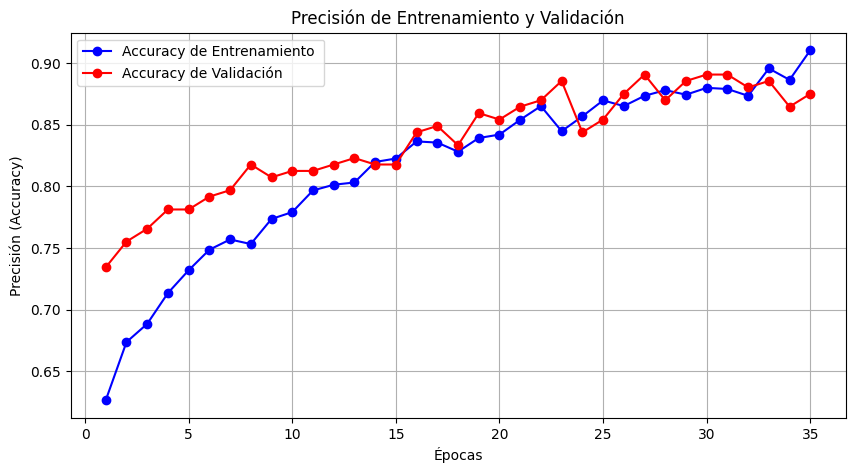

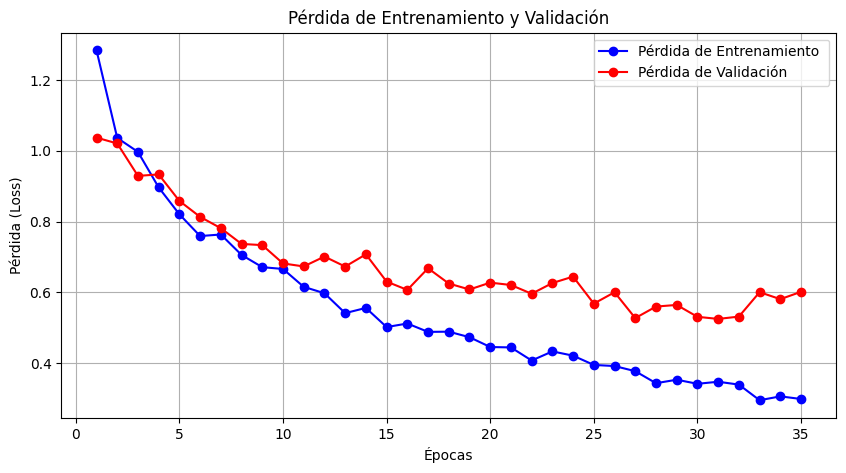

In [47]:
import matplotlib.pyplot as plt

#historial del finetuning
history_dict = history_vgg2.history

# Gráfica de accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Accuracy de Entrenamiento ')
plt.plot(epochs, val_acc, 'ro-', label='Accuracy de Validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de la función de pérdida
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Pérdida de Entrenamiento ')
plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación ')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show()

De todos los modelos anteriores, seleccionaré el de mayor precisión en entrenamiento para probar finalmente con el conjuto de prueba y obtener la precisión final, probaré con el modelo de ResNet.

In [37]:
# carpeta para test ('plant_dataset/test/')
setup_folders(df_final_test, 'test')

In [82]:
import tensorflow as tf
import numpy as np

# --- Parámetros ---
TEST_DIR = "plant_dataset/test/"
BATCH_SIZE = 32

# --- Dataset A (Para ResNet) ---
IMAGE_SIZE_RESNET = (224, 224)
test_dataset= tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMAGE_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False # ¡NUNCA barajar el test set!
)
class_names = test_dataset.class_names
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

model = load_model("resnet_fine_tuning.keras") #modelo para predecir
loss_final, accuracy_final = model.evaluate(test_dataset)
print(f"   Pérdida (Loss) en el Test Set: {loss_final:.4f}")
print(f"   Precisión (Accuracy) en el Test Set: {accuracy_final * 100:.2f}%")

Found 547 files belonging to 4 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.8940 - loss: 0.3117
   Pérdida (Loss) en el Test Set: 0.3117
   Precisión (Accuracy) en el Test Set: 89.40%


In [84]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_prob = model.predict(test_dataset)
# 2. Convertir probabilidades a clases (0, 1, 2, o 3)
y_pred = np.argmax(y_pred_prob, axis=1)

# 3. Obtener todas las etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# 4. Imprimir el reporte
print(classification_report(y_true, y_pred, target_names=class_names))

18/18 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step
                   precision    recall  f1-score   support

          healthy       0.87      0.94      0.90       155
multiple_diseases       0.50      0.11      0.18        27
             rust       0.93      0.95      0.94       187
             scab       0.89      0.92      0.91       178

         accuracy                           0.89       547
        macro avg       0.80      0.73      0.73       547
     weighted avg       0.88      0.89      0.88       547



Resultados finales:
- Accuracy: $89.40$%
- Loss: $0.3117$